In [ ]:
#pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [ ]:
import cv2 
import numpy as np 
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion from the frame that OpenCV grabs
    image.flags.writeable = False #sets the image writeable status to false

    results = model.process(image) #makes the detection, where MediaPipe is actually detecting from the frame ---- that OpenCV grabs [making prediction]
    
    image.flags.writeable = True #sets the image to writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion back
    return image, results 

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121,22,76), thickness = 2, circle_radius = 4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness = 2, circle_radius = 2)
        )

    # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [ ]:

cap = cv2.VideoCapture(0)

#set mediapipe model - will make initial detection, and then track keypoints - setting the different values. We can change these values
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:   
    while cap.isOpened():

        #feed, looping every single frame
        ret, frame = cap.read()

        #Make the detections using mediapipe_detection function
        image, results = mediapipe_detection(frame, holistic)
        print(results)


        #Draw landmarks
        draw_landmarks(image, results)




        #show the frame!
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

"results.pose_landmarks" is formatted as such: 
landmark {
    x: ""
    y: ""
    z: ""
    visibility: ""
}

where "results.pose_landmarks.landmark" is unformatted array, but can access each of 33 with "results.pose_landmarks.landmark[i].visibility/x/y/z"

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)


    #this is only for tutorial - not necessary for pose recognition
    # lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    # rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    # return np.concatenate([pose, lh, rh])
    return pose
    #######

This file directory may be useful ...!

In [ ]:
##CREATING TRAINING DATA

DATA_PATH = os.path.join("MP_DATA")
actions = np.array(['lunge','fleche','nothing'])

#30 videos of data
no_sequences = 50

#30 frames of length
sequence_length = 30

In [ ]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

COLLECTING DATA NOW!! THIS IS ONLY FOR TUTORIAL


In [ ]:

cap = cv2.VideoCapture(0)

#set mediapipe model - will make initial detection, and then track keypoints - setting the different values. We can change these values
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:   

    for action in actions: 
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):

                #feed, looping every single frame
                ret, frame = cap.read()

                #Make the detections using mediapipe_detection function
                image, results = mediapipe_detection(frame, holistic)


                #Draw landmarks
                draw_landmarks(image, results)

                #apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, '{} Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                               
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, '{} Number {}'.format(action, sequence), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

                
    cap.release()
    cv2.destroyAllWindows()

Preprocessing Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

sequences, labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)), allow_pickle = True)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

In [ ]:
y_test.shape

Build the Train the LSTM Neural Network

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

Other networks: Many state of the art models currently use a number of CNN layers + LSTM layers. Use pre-trained mobile net followed by LSTM layers. However, using our training data, no where near same accuracy. 

Our network: MediaPipe Holistic + LSTM layers
1) Less Data Required
2) Faster to Train
3) Faster Detections

Using CNN Layer => a ton more data and parameters

In [98]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation = 'relu', input_shape = (30,132))) #30 frames, with 132 keypoints
model.add(LSTM(128, return_sequences=True, activation = 'relu'))  
model.add(LSTM(64, return_sequences=False, activation = 'relu'))  #because next layer is dense layer - Andrew Ng Deep Learning Specialization
model.add(Dense(64,  activation = 'relu'))  
model.add(Dense(32,  activation = 'relu'))  
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer = "Adam", loss = 'categorical_crossentropy', metrics = ['categorical_accuracy']) #need to use categorical crossentropy because multi-class classification model

In [99]:
model.fit(x_train, y_train, epochs = 110, callbacks = [tb_callback])

Epoch 1/110
3/3 [==============================] - 4s 417ms/step - loss: 1.0967 - categorical_accuracy: 0.3333
Epoch 2/110
3/3 [==============================] - 1s 404ms/step - loss: 1.0947 - categorical_accuracy: 0.3556
Epoch 3/110
3/3 [==============================] - 1s 359ms/step - loss: 0.9627 - categorical_accuracy: 0.5889
Epoch 4/110
3/3 [==============================] - 1s 381ms/step - loss: 0.9570 - categorical_accuracy: 0.6667
Epoch 5/110
3/3 [==============================] - 1s 407ms/step - loss: 0.8377 - categorical_accuracy: 0.5778
Epoch 6/110
3/3 [==============================] - 1s 365ms/step - loss: 0.6460 - categorical_accuracy: 0.7000
Epoch 7/110
3/3 [==============================] - 1s 372ms/step - loss: 1.1872 - categorical_accuracy: 0.6778
Epoch 8/110
3/3 [==============================] - 1s 374ms/step - loss: 0.8674 - categorical_accuracy: 0.7556
Epoch 9/110
3/3 [==============================] - 1s 357ms/step - loss: 0.7868 - categorical_accuracy: 0.7444
E

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            50432     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 204,995
Trainable params: 204,995
Non-tr

In [101]:
results = model.predict(x_test)
# actions[np.argmax(res[4])]
# actions[np.argmax(y_test[4])]
# res is modeled as such. res = [0.1, 0.5, 0.4] s.t. each value is the probability of an action occurring 

In [ ]:
model.save('action_classifier.h5')
model.built = True
model.load_weights('action_classifier.h5')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

Evaluating Model Performance

In [83]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(x_test)
ytrue = np.argmax(y_test, axis = 1).tolist()
yhat = np.argmax(yhat, axis = 1).tolist()

multilabel_confusion_matrix(ytrue, yhat) #top left, bottom right are true positive, true negative
# accuracy_score(ytrue, yhat)




array([[[39,  2],
        [ 0, 19]],

       [[35,  0],
        [ 2, 23]],

       [[44,  0],
        [ 0, 16]]], dtype=int64)

In [69]:
from sklearn.metrics import confusion_matrix
import itertools

In [74]:
y_test

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0,

[[19  0  0]
 [ 2 23  0]
 [ 0  0 16]]
Confusion matrix, without normalization


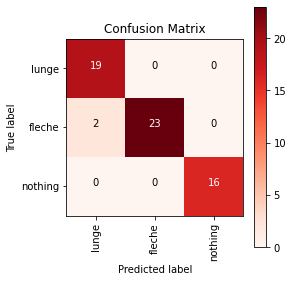

In [96]:


# define function to implement confusion matrix with normalization capability
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred_log = model.predict(x_test)
y_pred_log = np.argmax(y_pred_log,axis=1)
y_test1 = np.argmax(y_test, axis=1)
cnf_rtree = confusion_matrix(y_test1, y_pred_log)

print(cnf_rtree)

fig = plt.figure()
fig.set_size_inches(4, 4, forward=True)
plot_confusion_matrix(cnf_rtree, classes=['lunge','fleche','nothing'],
                      title='Confusion Matrix')

Test in Real-Time

In [ ]:


colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.7 #confidence metric - render if higher than the threshold

cap = cv2.VideoCapture(0)

#set mediapipe model - will make initial detection, and then track keypoints - setting the different values. We can change these values
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:   
    while cap.isOpened():

        #feed, looping every single frame
        ret, frame = cap.read()

        #Make the detections using mediapipe_detection function
        image, results = mediapipe_detection(frame, holistic)


        #Draw landmarks
        draw_landmarks(image, results)


        #prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis = 0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
            if np.unique(predictions[-10:])[0] == np.argmax(res): #check for stability over past 10 frames
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
        
        # cv2.rectangle(image, (0,0), (640,640), (245,117,16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

        #show the frame!
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)]